<a href="https://colab.research.google.com/github/KailasVS666/risk-prediction-model/blob/main/risk_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn xgboost shap


In [3]:
from google.colab import files
uploaded = files.upload()

Saving student+performance.zip to student+performance.zip


In [4]:
import zipfile

zip_path = "student+performance.zip"
extract_path = "student_performance"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import zipfile, os, pandas as pd

# Step 1: Extract outer zip
outer_zip = "student+performance.zip"
outer_extract = "student_performance"

with zipfile.ZipFile(outer_zip, 'r') as zip_ref:
    zip_ref.extractall(outer_extract)

# Step 2: Extract inner zip
inner_zip = os.path.join(outer_extract, "student.zip")
inner_extract = os.path.join(outer_extract, "student_data")

with zipfile.ZipFile(inner_zip, 'r') as zip_ref:
    zip_ref.extractall(inner_extract)

# Step 3: List files to confirm
print("Files extracted:", os.listdir(inner_extract))

# Step 4: Load dataset
df = pd.read_csv(os.path.join(inner_extract, "student-mat.csv"), sep=";")
df.head()


Files extracted: ['student-merge.R', 'student-por.csv', 'student.txt', 'student-mat.csv']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
# Define risk categories based on final grade (G3)
def categorize_risk(g3):
    if g3 < 10:
        return "High"
    elif g3 < 15:
        return "Medium"
    else:
        return "Low"

df["risk_level"] = df["G3"].apply(categorize_risk)

# Check distribution
print(df["risk_level"].value_counts())
df[["G3", "risk_level"]].head(10)


risk_level
Medium    192
High      130
Low        73
Name: count, dtype: int64


,G3,risk_level
0,6,High
1,6,High
2,10,Medium
3,15,Low
4,10,Medium
5,15,Low
6,11,Medium
7,6,High
8,19,Low
9,15,Low


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# 1. Features and target
X = df.drop(columns=["risk_level", "G1", "G2", "G3"])  # drop grades + target
y = df["risk_level"]

# 2. Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# 3. Preprocessing: OneHot for categoricals, Scale for numerics
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# 4. Build pipeline with RandomForest (baseline model)
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model.fit(X_train, y_train)

# Evaluate on test set
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.50      0.31      0.38        26
         Low       0.43      0.20      0.27        15
      Medium       0.50      0.74      0.60        38

    accuracy                           0.49        79
   macro avg       0.48      0.41      0.42        79
weighted avg       0.49      0.49      0.46        79



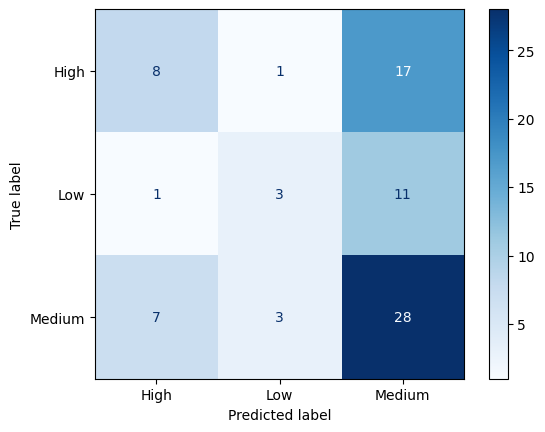

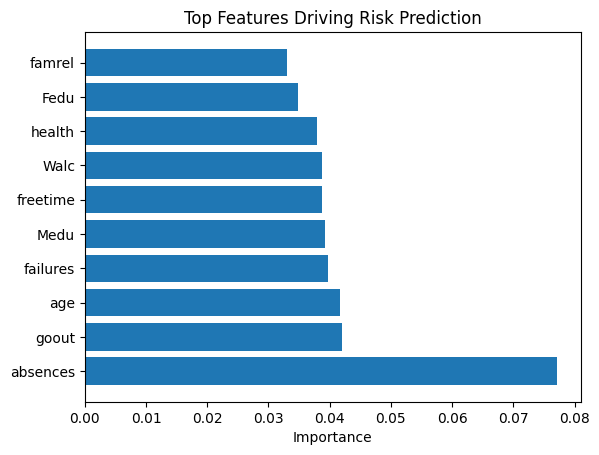

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.show()

# Feature Importance (RandomForest only)
rf = model.named_steps["clf"]
importances = rf.feature_importances_

# Get feature names from preprocessor
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + list(num_cols)

# Plot top features
feat_imp = sorted(zip(importances, all_feature_names), reverse=True)[:10]
scores, names = zip(*feat_imp)

plt.barh(names, scores)
plt.xlabel("Importance")
plt.title("Top Features Driving Risk Prediction")
plt.show()


              precision    recall  f1-score   support

        High       0.60      0.35      0.44        26
         Low       0.25      0.07      0.11        15
      Medium       0.53      0.84      0.65        38

    accuracy                           0.53        79
   macro avg       0.46      0.42      0.40        79
weighted avg       0.50      0.53      0.48        79



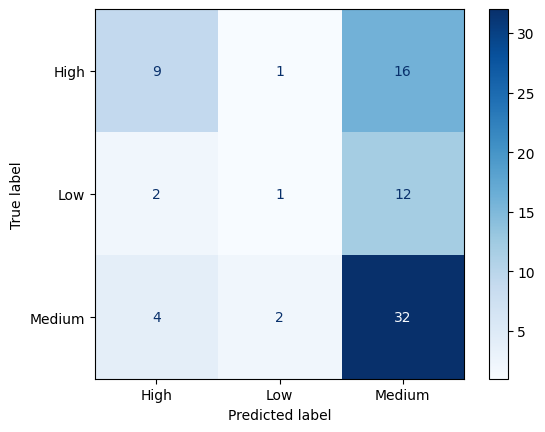

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Rebuild model with class_weight='balanced'
model_balanced = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# Train
model_balanced.fit(X_train, y_train)

# Predict
y_pred_balanced = model_balanced.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model_balanced, X_test, y_test, cmap="Blues")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:32:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

        High       0.62      0.38      0.48        26
         Low       0.33      0.27      0.30        15
      Medium       0.55      0.74      0.63        38

    accuracy                           0.53        79
   macro avg       0.50      0.46      0.47        79
weighted avg       0.53      0.53      0.52        79



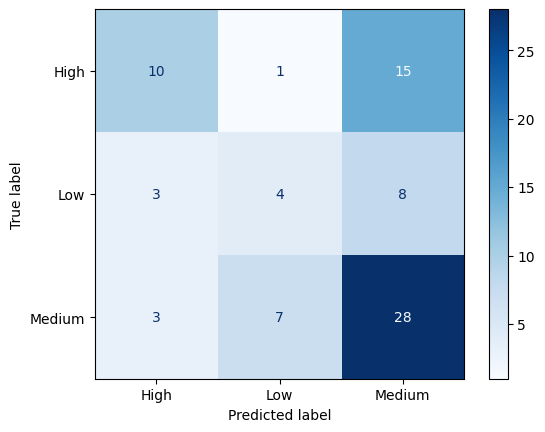

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels (High, Low, Medium) → (0,1,2)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Build pipeline with XGBoost
xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        use_label_encoder=False
    ))
])

# Train
xgb_model.fit(X_train, y_train_enc)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Decode predictions back to labels for readability
y_pred_labels = le.inverse_transform(y_pred_xgb)

# Evaluation
print(classification_report(y_test, y_pred_labels))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels, cmap="Blues")
plt.show()


In [14]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# One-hot encode categorical features
X_encoded = pd.get_dummies(X_train, drop_first=True)

# Apply SMOTE on numeric dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_encoded, y_train_enc)

print("Before SMOTE:", Counter(y_train_enc))
print("After SMOTE:", Counter(y_train_res))


Before SMOTE: Counter({np.int64(2): 154, np.int64(0): 104, np.int64(1): 58})
After SMOTE: Counter({np.int64(0): 154, np.int64(2): 154, np.int64(1): 154})


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

        High       0.55      0.42      0.48        26
         Low       0.33      0.27      0.30        15
      Medium       0.53      0.66      0.59        38

    accuracy                           0.51        79
   macro avg       0.47      0.45      0.45        79
weighted avg       0.50      0.51      0.50        79



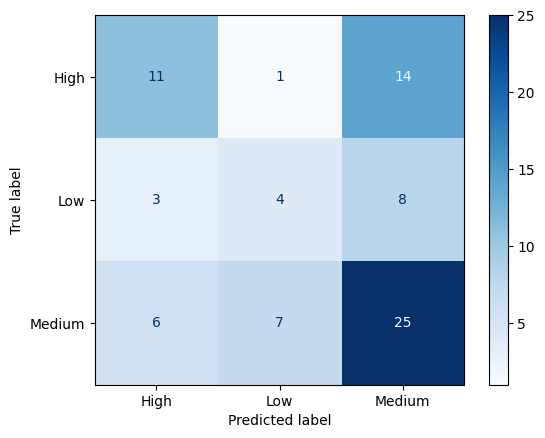

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Rebuild pipeline with XGBoost using the resampled data
xgb_model_smote = Pipeline([
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        use_label_encoder=False # This parameter is deprecated and can be removed
    ))
])

# Train on the SMOTE-resampled data
xgb_model_smote.fit(X_train_res, y_train_res)

# One-hot encode X_test to match X_train_res before prediction
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Ensure columns match between training and test sets after encoding
# This is important if some categories are only present in train or test
train_cols = X_train_res.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
X_test_encoded = X_test_encoded[train_cols]


# Predict on the encoded test set
y_pred_xgb_smote = xgb_model_smote.predict(X_test_encoded)

# Decode predictions back to labels for readability
y_pred_labels_smote = le.inverse_transform(y_pred_xgb_smote)

# Evaluation
print(classification_report(y_test, y_pred_labels_smote))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels_smote, cmap="Blues")
plt.show()

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:49:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Best cross-validation weighted F1-score:  0.6711510596453308

Classification Report on Test Set with Best Model:
              precision    recall  f1-score   support

        High       0.47      0.35      0.40        26
         Low       0.36      0.33      0.34        15
      Medium       0.50      0.61      0.55        38

    accuracy                           0.47        79
   macro avg       0.44      0.43      0.43        79
weighted avg       0.46      0.47      0.46        79



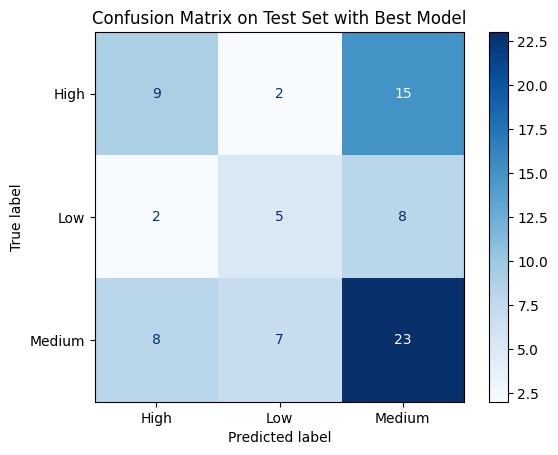

In [22]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.7, 0.8, 0.9],
    'clf__colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the GridSearchCV object
# We use the xgb_model_smote pipeline defined previously
grid_search = GridSearchCV(
    estimator=xgb_model_smote,
    param_grid=param_grid,
    scoring='f1_weighted',  # Use weighted F1-score for imbalanced data
    cv=3,  # Cross-validation folds
    verbose=1,
    n_jobs=-1 # Use all available cores
)

# Fit the grid search to the SMOTE-resampled training data
# Note: GridSearchCV will handle the fitting of the pipeline internally
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation weighted F1-score: ", grid_search.best_score_)

# Evaluate the best model on the original test set
best_xgb_model = grid_search.best_estimator_

# Predict on the original test set
y_pred_best_xgb = best_xgb_model.predict(X_test_encoded)

# Decode predictions back to labels
y_pred_labels_best_xgb = le.inverse_transform(y_pred_best_xgb)

# Evaluation
print("\nClassification Report on Test Set with Best Model:")
print(classification_report(y_test, y_pred_labels_best_xgb))

# Confusion matrix for the best model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels_best_xgb, cmap="Blues")
plt.title("Confusion Matrix on Test Set with Best Model")
plt.show()